In [15]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN

Epoch 0: Loss = 67.397987
Epoch 500: Loss = 48.217495
Epoch 1000: Loss = 48.217495
Epoch 1500: Loss = 48.217495
Epoch 2000: Loss = 48.217495
Epoch 2500: Loss = 48.217495


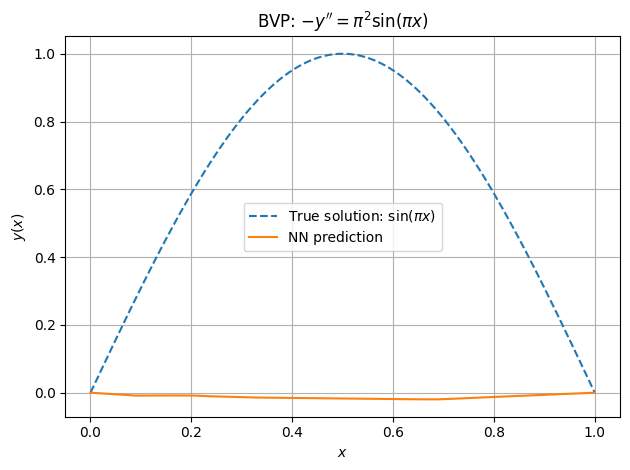

In [38]:
def compute_derivative(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

# Loss function
def loss_function_bvp(model, x_collocation, gamma=100.0):
    x_collocation.requires_grad_(True)
    y = model(x_collocation)
    dy_dx = compute_derivative(y, x_collocation)
    d2y_dx2 = compute_derivative(dy_dx, x_collocation)

    # PDE residual: -y'' - pi^2 sin(pi x)
    f = torch.pi**2 * torch.sin(torch.pi * x_collocation)
    residual = -d2y_dx2 - f
    loss_pde = torch.mean(residual**2)

    # Enforce boundary conditions: y(0) = 0, y(1) = 0
    y0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    y1 = model(torch.tensor([[1.0]], dtype=torch.float32))
    loss_bc = (y0**2 + y1**2).mean()

    return loss_pde + gamma * loss_bc

# Training loop
def train_bvp(model, epochs=3000, lr=1e-3, n_collocation=100, gamma=100.0, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_collocation = torch.linspace(0, 1, n_collocation).view(-1, 1)

    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function_bvp(model, x_collocation, gamma=gamma)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        loss_history.append(loss.item())
    return loss_history

# Evaluation and plotting
def plot_bvp_solution(model):
    x_test = torch.linspace(0, 1, 200).view(-1, 1)
    with torch.no_grad():
        y_pred = model(x_test).numpy()
    y_true = np.sin(np.pi * x_test.numpy())

    plt.plot(x_test, y_true, "--", label="True solution: $\\sin(\\pi x)$")
    plt.plot(x_test, y_pred, label="NN prediction")
    plt.title("BVP: $-y'' = \\pi^2 \\sin(\\pi x)$")
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Example usage ----
model = FeedforwardNN(input_dim=1, output_dim=1, hidden_layers=3, hidden_units=20, activation='relu')
train_bvp(model, epochs=3000, lr=1e-3, gamma=100.0)
plot_bvp_solution(model)

In [40]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))   # 1 to 10 layers
widths = list(range(1, 21))         # 1 to 20 neurons per layer

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training model: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)

            start_time = time.time()
            train_bvp(model, epochs=2500, lr=1e-3, gamma=100.0, verbose=False)
            duration = time.time() - start_time

            # Evaluate PDE residual MSE
            x_eval = torch.linspace(0, 1, 200).view(-1, 1)
            f_eval = torch.pi**2 * torch.sin(torch.pi * x_eval)
            x_eval.requires_grad_(True)
            y_pred = model(x_eval)
            dy_dx = compute_derivative(y_pred, x_eval)
            d2y_dx2 = compute_derivative(dy_dx, x_eval)
            residual = -d2y_dx2 - f_eval
            mse = torch.mean(residual**2).item()

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("Data/BVP_data/poisson_bvp_results.csv", index=False)

Training model: activation=tanh, layers=1, width=1
Training model: activation=tanh, layers=1, width=2
Training model: activation=tanh, layers=1, width=3
Training model: activation=tanh, layers=1, width=4
Training model: activation=tanh, layers=1, width=5
Training model: activation=tanh, layers=1, width=6
Training model: activation=tanh, layers=1, width=7
Training model: activation=tanh, layers=1, width=8
Training model: activation=tanh, layers=1, width=9
Training model: activation=tanh, layers=1, width=10
Training model: activation=tanh, layers=1, width=11
Training model: activation=tanh, layers=1, width=12
Training model: activation=tanh, layers=1, width=13
Training model: activation=tanh, layers=1, width=14
Training model: activation=tanh, layers=1, width=15
Training model: activation=tanh, layers=1, width=16
Training model: activation=tanh, layers=1, width=17
Training model: activation=tanh, layers=1, width=18
Training model: activation=tanh, layers=1, width=19
Training model: activ

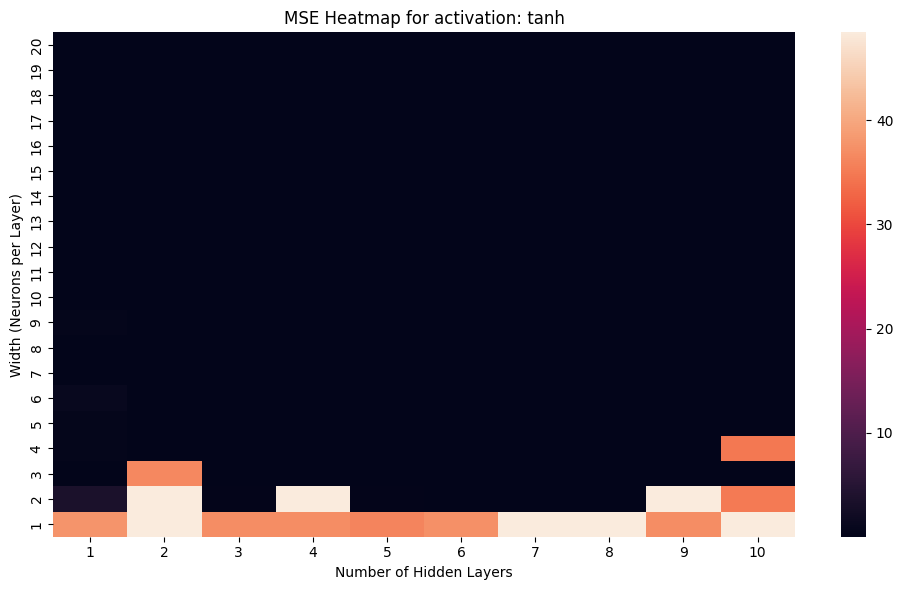

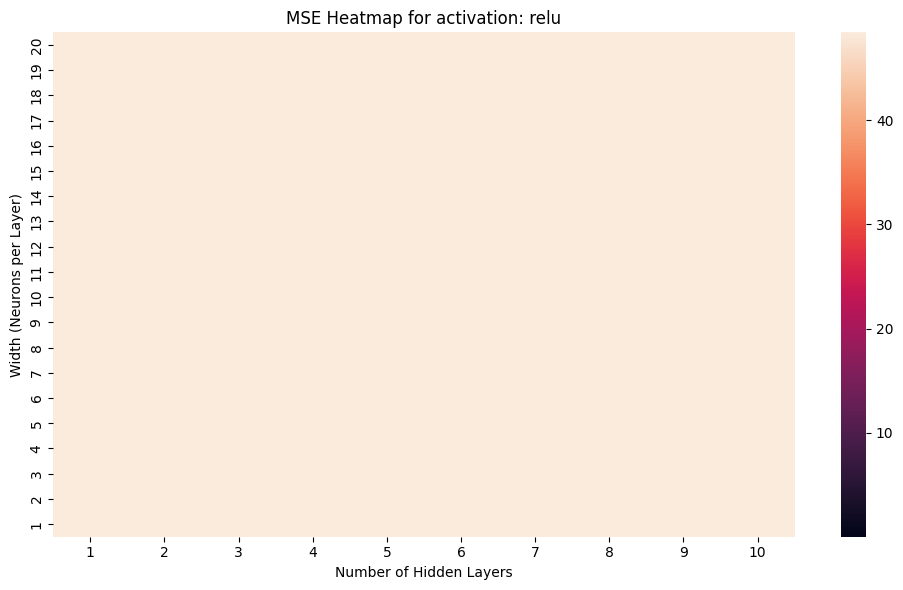

In [ ]:
# Ensure the heatmaps use the same scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

results_df = pd.DataFrame(results)
for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)
    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_bvp_poisson_{act}.png", dpi=300)
    plt.show()

Training model: activation=tanh, layers=9, width=18


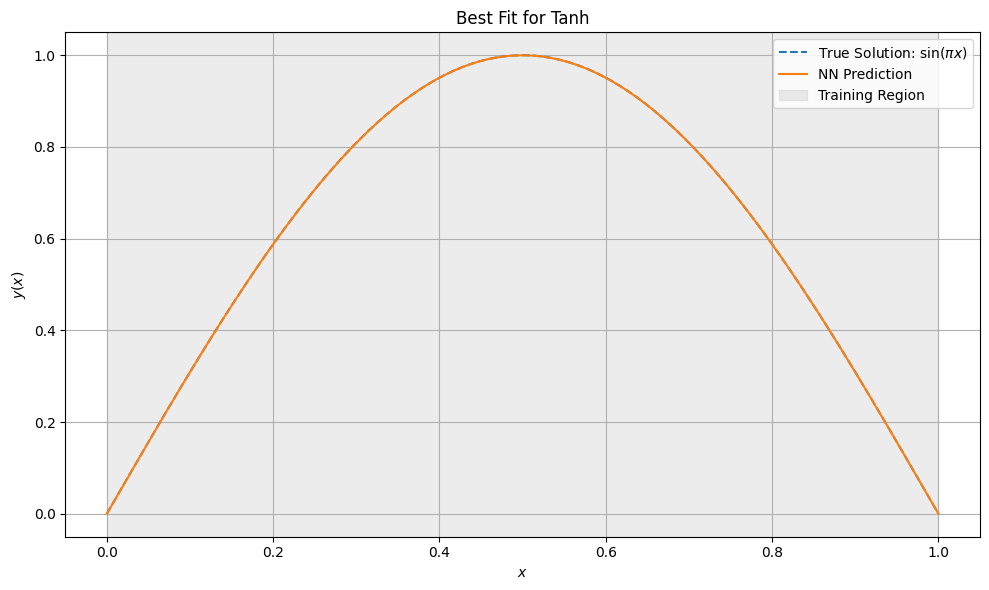

Training model: activation=relu, layers=1, width=1


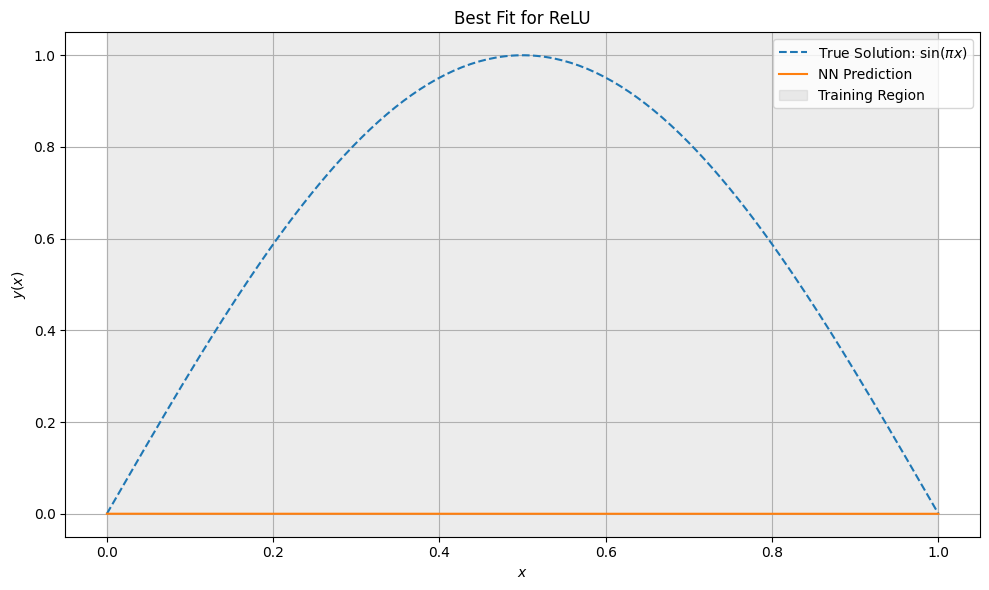

Training model: activation=tanh, layers=2, width=2


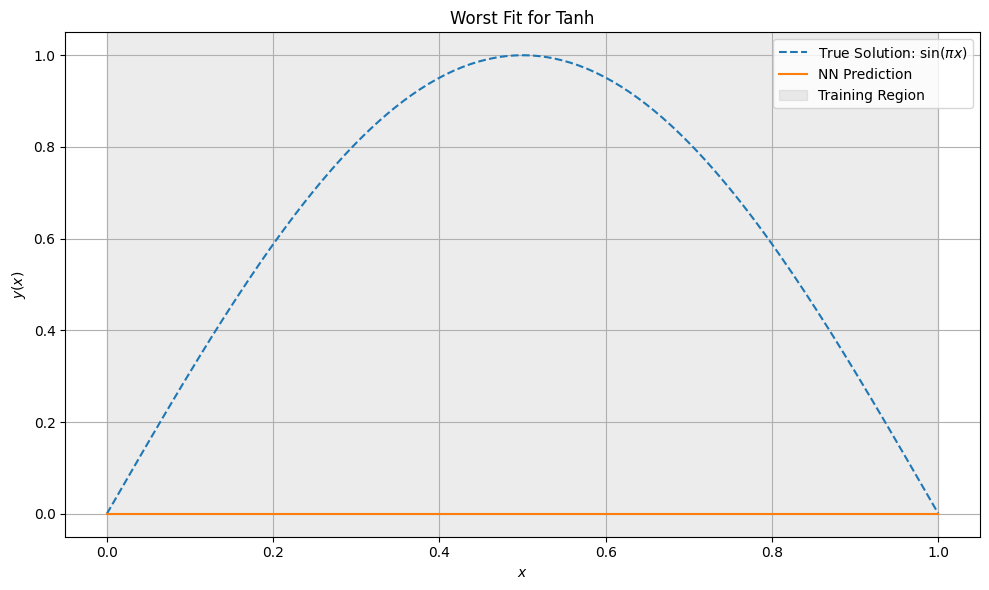

Training model: activation=relu, layers=1, width=1


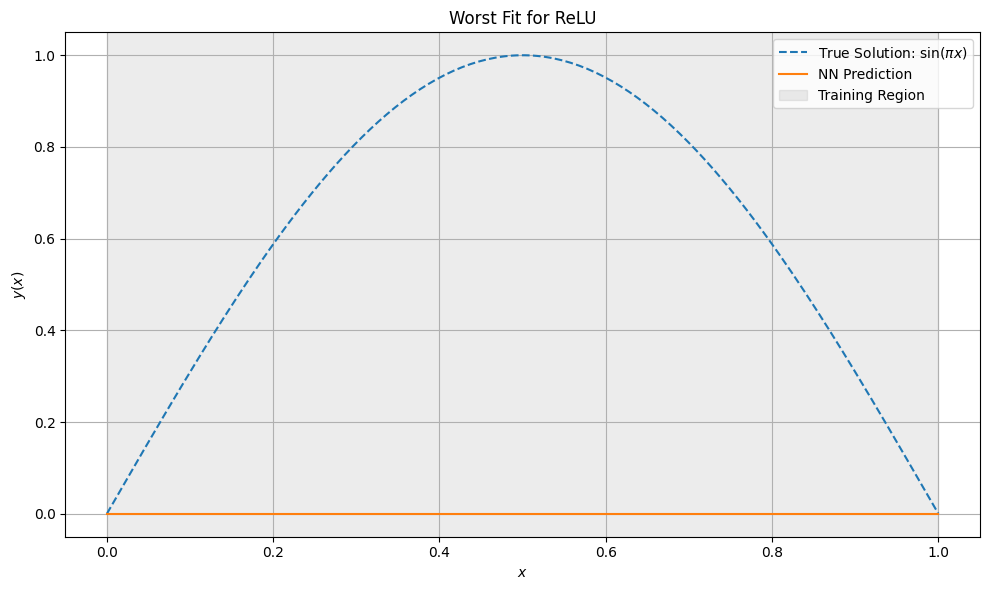

In [42]:
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_row = df_sub.loc[df_sub['mse'].idxmin()]
    worst_row = df_sub.loc[df_sub['mse'].idxmax()]
    best_configs[act] = best_row
    worst_configs[act] = worst_row


def plot_poisson_bvp_fit(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']
    print(f"Training model: activation={act}, layers={layers}, width={width}")
    
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)

    # Train the model
    train_bvp(model, epochs=3000, lr=1e-3, gamma=100.0, verbose=False)

    # Evaluation
    x_test = torch.linspace(0, 1, 200).view(-1, 1)
    y_true = np.sin(np.pi * x_test.numpy())
    
    with torch.no_grad():
        y_pred = model(x_test).numpy()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_test.numpy(), y_true, "--", label="True Solution: $\\sin(\\pi x)$")
    plt.plot(x_test.numpy(), y_pred, label="NN Prediction")
    plt.axvspan(0, 1, color="gray", alpha=0.15, label="Training Region")

    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save
    filename = f"report/graphics/bvp_poisson_{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Plot best and worst fits for each activation
plot_poisson_bvp_fit(best_configs["tanh"], "Best Fit for Tanh", save_prefix="best_fit")
plot_poisson_bvp_fit(best_configs["relu"], "Best Fit for ReLU", save_prefix="best_fit")
plot_poisson_bvp_fit(worst_configs["tanh"], "Worst Fit for Tanh", save_prefix="worst_fit")
plot_poisson_bvp_fit(worst_configs["relu"], "Worst Fit for ReLU", save_prefix="worst_fit")


Epoch 0, Loss: 16.440653
Epoch 500, Loss: 0.041356
Epoch 1000, Loss: 0.015297
Epoch 1500, Loss: 0.010424
Epoch 2000, Loss: 0.007027
Epoch 2500, Loss: 0.005269
Epoch 3000, Loss: 0.004268
Epoch 3500, Loss: 0.003132
Epoch 4000, Loss: 0.002201
Epoch 4500, Loss: 0.001437


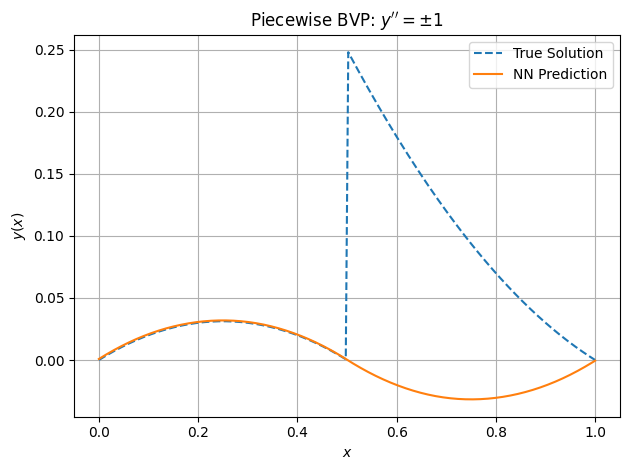

In [29]:
def compute_derivative(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def rhs_piecewise(x):
    return torch.where(x < 0.5, -torch.ones_like(x), torch.ones_like(x))

def loss_function_piecewise_bvp(model, x_collocation, gamma=100.0):
    x_collocation.requires_grad_(True)
    y = model(x_collocation)
    dy_dx = compute_derivative(y, x_collocation)
    d2y_dx2 = compute_derivative(dy_dx, x_collocation)

    f = rhs_piecewise(x_collocation)
    loss_pde = torch.mean((d2y_dx2 - f)**2)

    y0 = model(torch.tensor([[0.0]]))
    y1 = model(torch.tensor([[1.0]]))
    loss_bc = (y0**2 + y1**2).mean()

    return loss_pde + gamma * loss_bc

def train_piecewise_bvp(model, epochs=3000, lr=1e-3, n_collocation=100, verbose=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    x_col = torch.linspace(0, 1, n_collocation).view(-1, 1)

    for epoch in range(epochs):
        opt.zero_grad()
        loss = loss_function_piecewise_bvp(model, x_col)
        loss.backward()
        opt.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return model

# Plot
def plot_solution(model):
    x = torch.linspace(0, 1, 200).view(-1, 1)
    y_pred = model(x).detach().numpy()
    x_np = x.numpy()
    y_true = np.where(x_np < 0.5, -0.5*x_np**2 + 0.25*x_np, 0.5*x_np**2 - 1.25*x_np + 0.75)
    plt.plot(x_np, y_true, '--', label='True Solution')
    plt.plot(x_np, y_pred, label='NN Prediction')
    plt.legend()
    plt.grid(True)
    plt.title('Piecewise BVP: $y\'\' = \\pm 1$')
    plt.xlabel('$x$')
    plt.ylabel('$y(x)$')
    plt.tight_layout()
    plt.show()

# Run
model = FeedforwardNN(1, 1, hidden_layers=10, hidden_units=20, activation='tanh')
model = train_piecewise_bvp(model, epochs=5000, verbose=True)
plot_solution(model)

In [30]:
activations = ['tanh', 'relu']
layer_counts = list(range(1, 11))   # 1 to 10 layers
widths = list(range(1, 21))         # 1 to 20 neurons per layer

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training model: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=1, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)

            start_time = time.time()
            train_piecewise_bvp(model, epochs=2500, lr=1e-3, verbose=False)
            duration = time.time() - start_time

            # Evaluate on dense grid
            x_eval = torch.linspace(0, 1, 200).view(-1, 1)
            f_eval = rhs_piecewise(x_eval)
            x_eval.requires_grad_(True)
            y_pred = model(x_eval)
            dy_dx = compute_derivative(y_pred, x_eval)
            d2y_dx2 = compute_derivative(dy_dx, x_eval)
            residual = d2y_dx2 - f_eval
            mse = torch.mean(residual**2).item()

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("Data/BVP_data/piecewise_bvp_results.csv", index=False)

Training model: activation=tanh, layers=1, width=1
Training model: activation=tanh, layers=1, width=2
Training model: activation=tanh, layers=1, width=3
Training model: activation=tanh, layers=1, width=4
Training model: activation=tanh, layers=1, width=5
Training model: activation=tanh, layers=1, width=6
Training model: activation=tanh, layers=1, width=7
Training model: activation=tanh, layers=1, width=8
Training model: activation=tanh, layers=1, width=9
Training model: activation=tanh, layers=1, width=10
Training model: activation=tanh, layers=1, width=11
Training model: activation=tanh, layers=1, width=12
Training model: activation=tanh, layers=1, width=13
Training model: activation=tanh, layers=1, width=14
Training model: activation=tanh, layers=1, width=15
Training model: activation=tanh, layers=1, width=16
Training model: activation=tanh, layers=1, width=17
Training model: activation=tanh, layers=1, width=18
Training model: activation=tanh, layers=1, width=19
Training model: activ

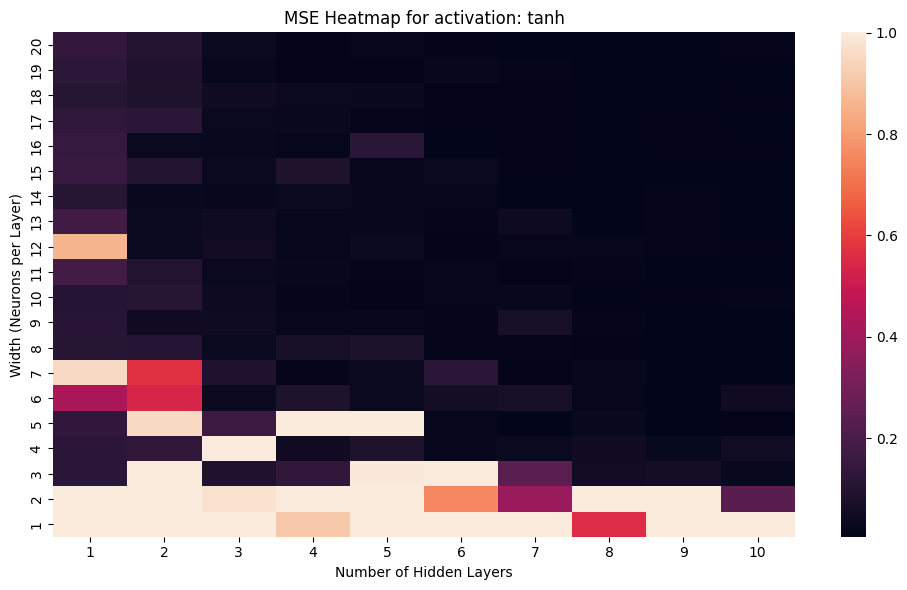

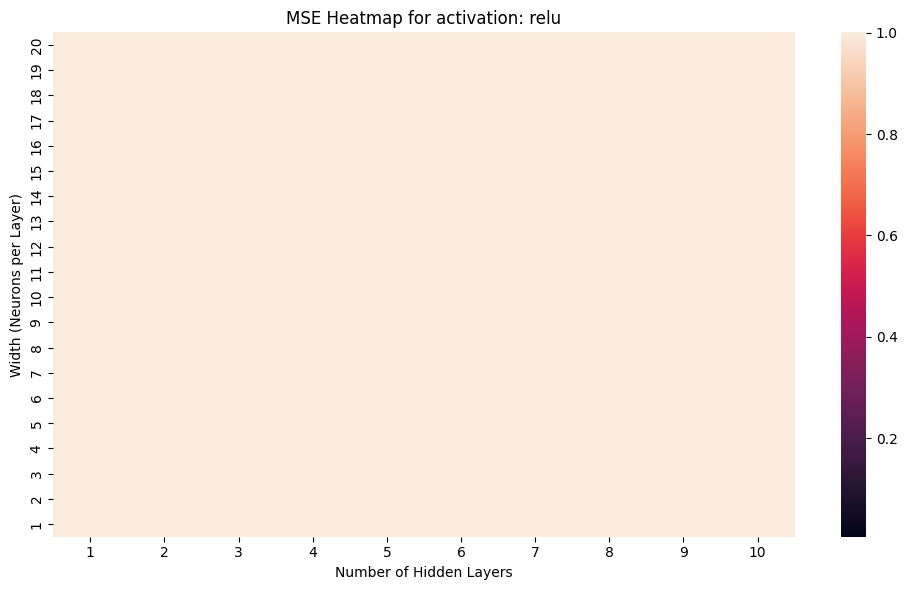

In [31]:
# Ensure the heatmaps use the same scale
global_min = results_df["mse"].min()
global_max = results_df["mse"].max()
log_norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

results_df = pd.DataFrame(results)
for act in results_df['activation'].unique():
    df_subset = results_df[results_df['activation'] == act]

    plt.figure(figsize=(10, 6))
    heatmap_data = df_subset.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm)
    plt.gca().invert_yaxis()
    plt.title(f"MSE Heatmap for activation: {act}")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Width (Neurons per Layer)")
    plt.tight_layout()
    plt.savefig(f"report/graphics/mse_heatmap_bvp_piecewise_{act}.png", dpi=300)
    plt.show()

10 13 tanh
Epoch 0, Loss: 1.663435
Epoch 500, Loss: 0.046600
Epoch 1000, Loss: 0.016598
Epoch 1500, Loss: 0.007373
Epoch 2000, Loss: 0.005375


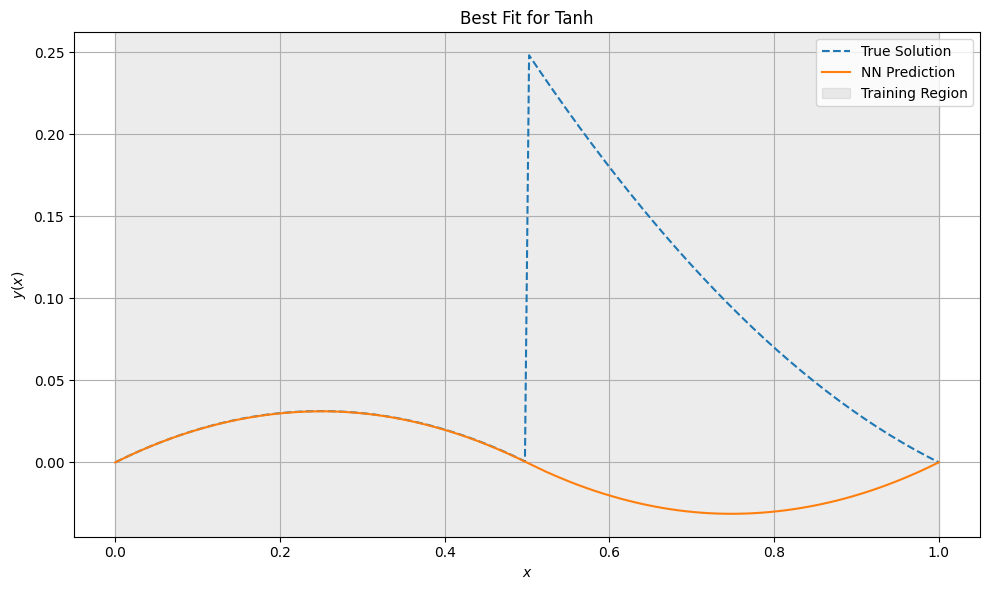

1 1 relu
Epoch 0, Loss: 11.613917
Epoch 500, Loss: 1.002833
Epoch 1000, Loss: 1.000000
Epoch 1500, Loss: 1.000000
Epoch 2000, Loss: 1.000000


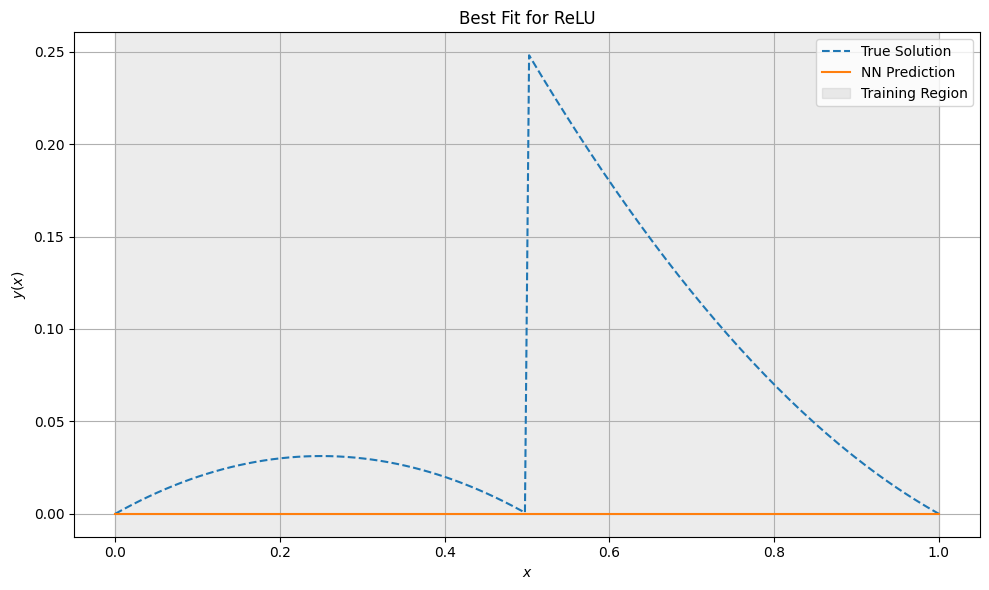

2 3 tanh
Epoch 0, Loss: 44.437359
Epoch 500, Loss: 1.054414
Epoch 1000, Loss: 0.991766
Epoch 1500, Loss: 0.988509
Epoch 2000, Loss: 0.984016


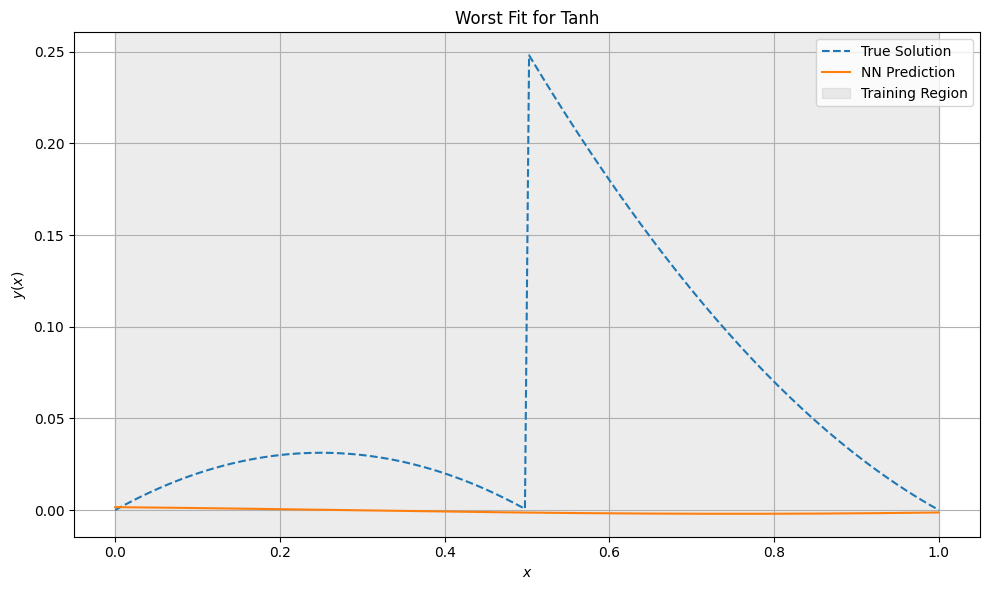

1 1 relu
Epoch 0, Loss: 6.548860
Epoch 500, Loss: 1.049334
Epoch 1000, Loss: 1.012976
Epoch 1500, Loss: 1.002792
Epoch 2000, Loss: 1.000400


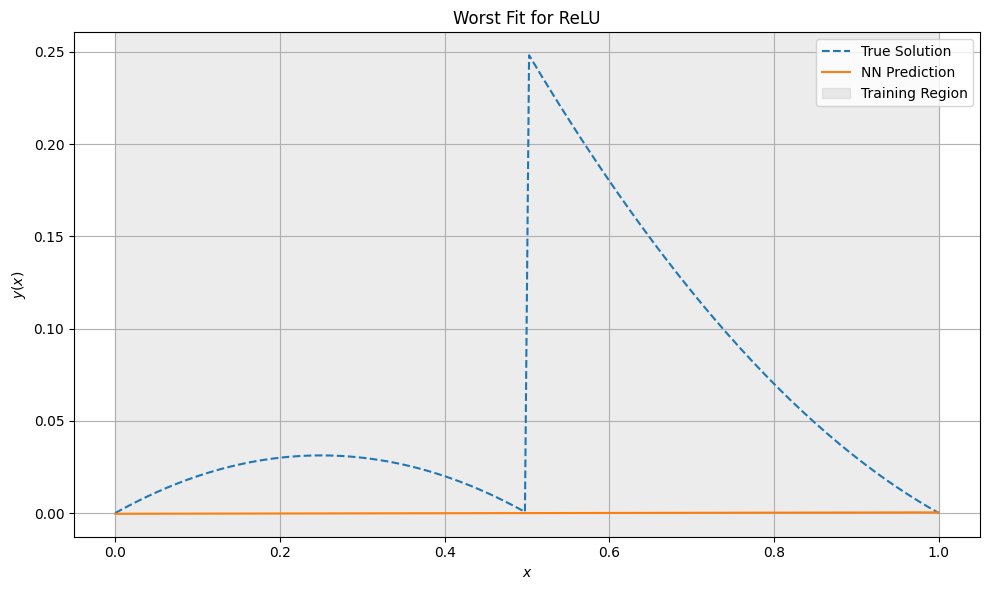

In [37]:
best_configs = {}
worst_configs = {}

for act in results_df['activation'].unique():
    df_sub = results_df[results_df['activation'] == act]
    best_row = df_sub.loc[df_sub['mse'].idxmin()]
    worst_row = df_sub.loc[df_sub['mse'].idxmax()]
    best_configs[act] = best_row
    worst_configs[act] = worst_row


def plot_fit(config, title, save_prefix="fit_plot"):
    layers = int(config['layers'])
    width = int(config['width'])
    act = config['activation']
    print(layers, width, act)
    model = FeedforwardNN(input_dim=1, output_dim=1,
                          hidden_layers=layers,
                          hidden_units=width,
                          activation=act)
    train_piecewise_bvp(model, epochs=2500, lr=1e-3, verbose=True)

    
    x_test = torch.linspace(0, 1, 200).view(-1, 1)
    y_pred = model(x_test).detach().numpy()
    x_np = x_test.numpy()
    y_true = np.where(x_np < 0.5, -0.5*x_np**2 + 0.25*x_np, 0.5*x_np**2 - 1.25*x_np + 0.75)

    with torch.no_grad():
        y_pred = model(x_test)

    plt.figure(figsize=(10, 6))
    plt.plot(x_test.numpy(), y_true, "--", label="True Solution")
    plt.plot(x_test.numpy(), y_pred.numpy(), label="NN Prediction")
    plt.axvspan(0, 1, color="gray", alpha=0.15, label="Training Region")

    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y(x)$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save with informative filename
    filename = f"report/graphics/bvp_piecewise_{save_prefix}_{act}_{layers}layers_{width}width.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()



plot_fit(best_configs["tanh"], "Best Fit for Tanh", save_prefix="best_fit")
plot_fit(best_configs["relu"], "Best Fit for ReLU", save_prefix="best_fit")
plot_fit(worst_configs["tanh"], "Worst Fit for Tanh", save_prefix="worst_fit")
plot_fit(worst_configs["relu"], "Worst Fit for ReLU", save_prefix="worst_fit")
